# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
!pip install --upgrade jupyter ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: jupyter in /root/.local/lib/python3.7/site-packages (1.0.0)
Requirement already up-to-date: ipywidgets in /root/.local/lib/python3.7/site-packages (8.0.6)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [7]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Create training set and define training dataloader and validation set and validation dataloader
train_data = torchvision.datasets.MNIST(root="tree", train=True, download=True, transform=None)
train_data_copy = np.copy(train_data.data.numpy())
train_data_tensor = torch.from_numpy(train_data_copy)

train_data = torchvision.datasets.MNIST(root="tree", train=True, download=True, transform=transform)
train_data.data = train_data_tensor
train_data, cv_data = torch.utils.data.random_split(train_data, [50000, 10000])

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=250, shuffle=True)
cv_loader = torch.utils.data.DataLoader(dataset=cv_data, batch_size=250)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root="tree", train=False, download=True, transform=None)
test_data_copy = np.copy(test_data.data.numpy())
test_data_tensor = torch.from_numpy(test_data_copy)

test_data = torchvision.datasets.MNIST(root="tree", train=False, download=True, transform=transform)
test_data.data = test_data_tensor
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=64)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I used the transforms.ToTensor(used for converting np.ndarray or PIL image from 0-255 to 0-1) because from What I have learnt, it is good to first make our features in the same range or scale, because When some features are larger than others, it can cause problems for our model during training. This is because features with larger values can dominate the learning process and cause the model to ignore the smaller features, causing bias in feature selection even though larger features are not important to the predictors, like the smaller features. Also I used transforms.Normalize(), because Normalization being common preprocessing step in machine learning will help improve the performance of my neural network. When we normalize an image, we scale the pixel values so that they have zero mean and unit variance. This can help to improve the convergence of the optimization algorithm and prevent the gradient from vanishing or exploding during training.

**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [8]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

9


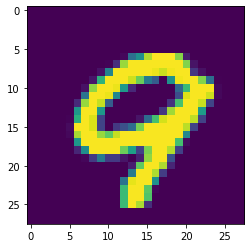

6


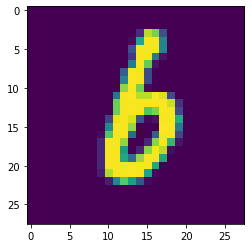

4


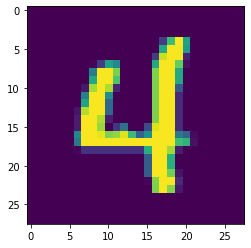

8


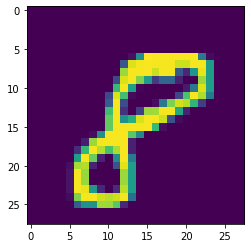

8


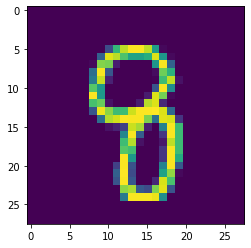

In [9]:
# Explore data
show5(train_loader)

7


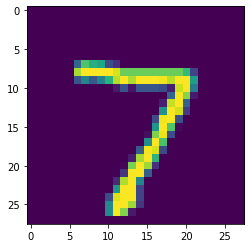

2


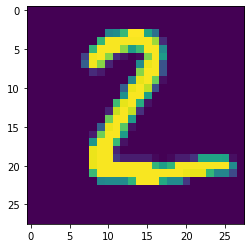

1


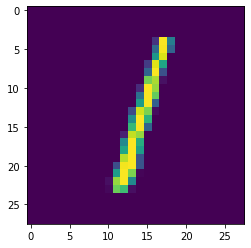

0


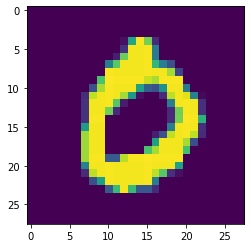

4


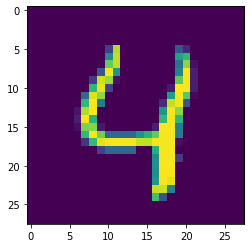

In [10]:
show5(test_loader)

3


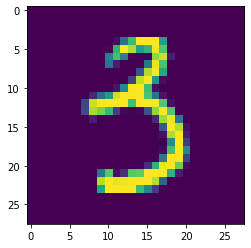

3


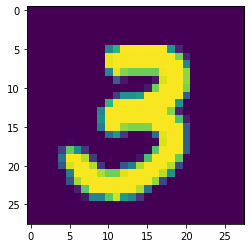

4


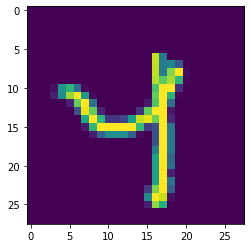

7


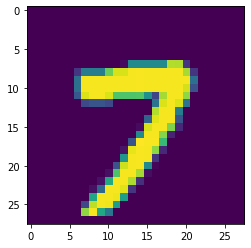

5


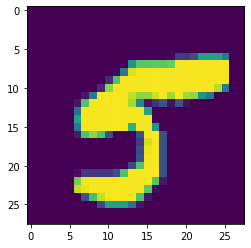

In [11]:
show5(cv_loader)

In [12]:
# Get the next batch of data from the DataLoader
data_iter = iter(train_loader)
images, labels = data_iter.next()

# Get the shape of the first image in the batch
image_shape = images[0].shape

print(image_shape)

torch.Size([1, 28, 28])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

flattening the batch_size training example of each mini batch of the total train_data set in the train_loader, ie train_data set is made up of 60000 images, approximately 6000 for each class, now this 60000 images is now divided into mini batch maybe 10, so 6000 images of a classes into 10 places but we still don't want to put whole 5000 for doing mini batch gradient descent before we use the remaining 54000, but still we want to use a small amount having the whole classes as how mini batch that is when train loader comes in place such that we only flatten that very small amount per batch of the train_data set but we could have done this using Transform.lambda() when preprocessing, but since we didn't we would do that in our feed forward network.

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [43]:
## YOUR CODE HERE ##
class neuralArch(nn.Module):
    def __init__(self):
        super(neuralArch, self).__init__()
        self.activation = F.relu
        self.softmax = F.log_softmax
        self.hidden1 = nn.Linear(28 * 28 * 1, 1024)
        self.hidden2 = nn.Linear(1024, 512)
        self.hidden3 = nn.Linear(512, 256)
        self.hidden4 = nn.Linear(256, 128)
        self.hidden5 = nn.Linear(128, 64)
        self.hidden6 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.activation(self.hidden3(x))
        x = self.activation(self.hidden4(x))
        x = self.activation(self.hidden5(x))
        x = self.activation(self.hidden6(x))
        x = self.softmax(self.output(x), dim=1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [44]:
# Instantiate model
net = neuralArch()
net.to(device)
# Choose an optimizer
optimizer = optim.SGD(net.parameters(), lr=0.03)

# Choose a loss function
criterion = nn.NLLLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [45]:
num_epochs = 12

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    
    train_loss_history.append(train_loss/len(train_loader))
    # Calculate training accuracy
    train_accuracy = (train_correct / len(train_loader.dataset)) * 100
    print(f'Epoch {epoch + 1} training accuracy: {train_accuracy:.2f}% training loss: {train_loss/len(train_loader):.5f}')


    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in cv_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    val_loss_history.append(val_loss/len(cv_loader))
    # Calculate validation accuracy
    val_accuracy = (val_correct / len(cv_loader.dataset)) * 100
    print(f'Epoch {epoch + 1} validation accuracy: {val_accuracy:.2f}% validation loss: {val_loss/len(cv_loader):.5f}')


Epoch 1 training accuracy: 11.45% training loss: 2.30238
Epoch 1 validation accuracy: 10.75% validation loss: 2.29996
Epoch 2 training accuracy: 11.33% training loss: 2.29407
Epoch 2 validation accuracy: 10.75% validation loss: 2.28853
Epoch 3 training accuracy: 16.82% training loss: 2.25881
Epoch 3 validation accuracy: 20.81% validation loss: 2.18325
Epoch 4 training accuracy: 26.96% training loss: 1.91616
Epoch 4 validation accuracy: 39.15% validation loss: 1.69239
Epoch 5 training accuracy: 51.56% training loss: 1.34725
Epoch 5 validation accuracy: 57.87% validation loss: 1.10184
Epoch 6 training accuracy: 69.83% training loss: 0.86727
Epoch 6 validation accuracy: 77.12% validation loss: 0.71126
Epoch 7 training accuracy: 79.86% training loss: 0.61744
Epoch 7 validation accuracy: 84.76% validation loss: 0.50767
Epoch 8 training accuracy: 85.62% training loss: 0.46938
Epoch 8 validation accuracy: 89.40% validation loss: 0.36914
Epoch 9 training accuracy: 89.60% training loss: 0.34830

Plot the training loss (and validation loss/accuracy, if recorded).

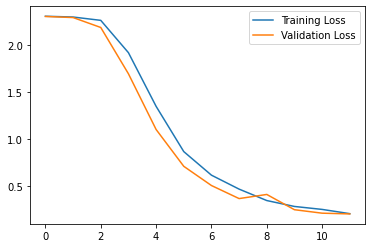

In [46]:
## YOUR CODE HERE ##
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [47]:
test_loss = 0.0
test_correct = 0
net.eval()
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)
    test_correct += (preds == labels).sum().item()
    test_loss += loss.item()
test_accuracy = (test_correct / len(test_loader.dataset)) * 100
print(f'test accuracy: {test_accuracy:.2f}% test loss: {test_loss/len(test_loader):.5f}')


test accuracy: 94.57% test loss: 0.18990


In [48]:
## YOUR CODE HERE ##
torch.save(net.state_dict(), 'deep_neural_net_model_weights.pth')

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [49]:
class NeuralArch(nn.Module):
    def __init__(self):
        super(NeuralArch, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x
    
# Instantiate model
net = NeuralArch()
net.to(device)
# Choose an optimizer
optimizer = optim.SGD(net.parameters(), lr=0.3)

# Choose a loss function
criterion = nn.NLLLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [50]:
num_epochs = 12

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    train_loss_history.append(train_loss/len(train_loader))
    # Calculate training accuracy
    train_accuracy = (train_correct / len(train_loader.dataset)) * 100
    print(f'Epoch {epoch + 1} training accuracy: {train_accuracy:.2f}% training loss: {train_loss/len(train_loader):.5f}')



    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in cv_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    val_loss_history.append(val_loss/len(cv_loader))
    # Calculate validation accuracy
    val_accuracy = (val_correct / len(cv_loader.dataset)) * 100
    print(f'Epoch {epoch + 1} validation accuracy: {val_accuracy:.2f}% validation loss: {val_loss/len(cv_loader):.5f}')

Epoch 1 training accuracy: 65.00% training loss: 1.05929
Epoch 1 validation accuracy: 95.73% validation loss: 0.14082
Epoch 2 training accuracy: 97.20% training loss: 0.09095
Epoch 2 validation accuracy: 97.37% validation loss: 0.09313
Epoch 3 training accuracy: 98.04% training loss: 0.06353
Epoch 3 validation accuracy: 93.80% validation loss: 0.21734
Epoch 4 training accuracy: 98.69% training loss: 0.04256
Epoch 4 validation accuracy: 98.36% validation loss: 0.05599
Epoch 5 training accuracy: 98.95% training loss: 0.03110
Epoch 5 validation accuracy: 98.67% validation loss: 0.04346
Epoch 6 training accuracy: 99.19% training loss: 0.02485
Epoch 6 validation accuracy: 98.92% validation loss: 0.04004
Epoch 7 training accuracy: 99.46% training loss: 0.01789
Epoch 7 validation accuracy: 98.92% validation loss: 0.04064
Epoch 8 training accuracy: 99.51% training loss: 0.01457
Epoch 8 validation accuracy: 98.93% validation loss: 0.03654
Epoch 9 training accuracy: 99.66% training loss: 0.01116

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

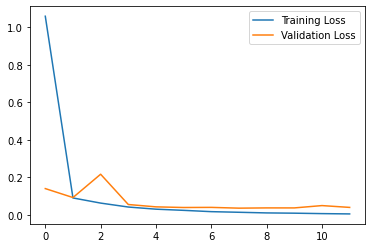

In [51]:
## YOUR CODE HERE ##
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [52]:
## YOUR CODE HERE ##
test_loss = 0.0
test_correct = 0
net.eval()
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)
    test_correct += (preds == labels).sum().item()
    test_loss += loss.item()
test_accuracy = (test_correct / len(test_loader.dataset)) * 100
print(f'test accuracy: {test_accuracy:.2f}% test loss: {test_loss/len(test_loader):.5f}')

test accuracy: 98.97% test loss: 0.03257


## Saving your model
Using `torch.save`, save your model for future loading.

In [53]:
## YOUR CODE HERE ##
torch.save(net.state_dict(), 'CNN_and_DEEP_net_model_weights.pth')